In [1]:
import pandas as pd

# Step 1: Load Data

In [2]:
from db_connect import get_connection

table_name = input("Enter the table name: ").strip()

# This portion of the project is using the player_table

engine = get_connection()
df = pd.read_sql(f"SELECT * FROM {table_name};", con = engine)
 

In [3]:
df.head()

,role,number,player,ht,wt,yr,g,min_pct,o_rtg,poss_pct,...,diff_blk_pct,diff_stl_pct,diff_f_cper40,diff_f_dper40,diff_ft_rate,diff_ft_pct,diff_fg_2_pct,diff_fg_3_pct,transfer,prev_team
0,Major Contributor,2.0,Julian Champagnie,6-8,215.0,Jr,31.0,82.5,105.4,25.5,...,0.3,0.7,-0.3,-0.6,-8.6,-0.106,-0.014,-0.043,False,St. John's
1,Significant Contributor,0.0,Posh Alexander,6-0,200.0,So,29.0,71.8,113.4,23.2,...,0.5,-0.6,-0.8,1.3,13.8,0.016,0.052,-0.082,False,St. John's
2,Significant Contributor,5.0,Dylan Addae-Wusu,6-4,235.0,So,32.0,61.0,101.5,20.3,...,0.3,0.6,-1.7,0.1,-3.0,-0.011,-0.098,0.110,False,St. John's
3,Role Player,23.0,Montez Mathis,6-4,210.0,Sr,32.0,60.5,98.3,18.5,...,-0.7,0.5,-0.8,-0.9,-2.4,0.049,0.038,-0.033,True,Rutgers
4,Role Player,1.0,Aaron Wheeler,6-9,205.0,Sr,31.0,53.0,110.1,19.7,...,1.4,-0.7,0.1,0.8,-0.8,0.083,-0.051,0.119,True,Purdue


In [4]:
df['year'].unique()

array([2022, 2023, 2024, 2019, 2020, 2021])

In [5]:
df['player_id'].nunique()

10991

# Step 2: Clean DataFrame

In [6]:
from player_dev_clean_df import clean_df

df_train, df_2024_transfers, df_2024_no_transfers, valid_players = clean_df(df)

print(df_train.shape, df_2024_transfers.shape, df_2024_no_transfers.shape)

(2433, 74) (218, 74) (278, 74)


# Step 3: Feature Selection, Engineering & Scaling

In [7]:
from transfer_vars import split_scale

train_data_scaled = split_scale(df_train)

scaler_x = train_data_scaled["scaler_x"]

# Step 4: Stack Models

In [8]:
from player_dev_ml_models import ml_stack_model_w_grid_search

best_stack_model = ml_stack_model_w_grid_search(train_data_scaled["X_train"], train_data_scaled["Y_train"])

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters: {'final_estimator__n_estimators': 100, 'gb__max_iter': 200, 'rf__max_depth': 10, 'rf__n_estimators': 100}


In [9]:
best_stack_model.fit(train_data_scaled["X_train"], train_data_scaled["Y_train"])

StackingRegressor(cv=5,
                  estimators=[('rf',
                               RandomForestRegressor(max_depth=10,
                                                     random_state=42)),
                              ('gb',
                               HistGradientBoostingRegressor(max_iter=200,
                                                             random_state=42))],
                  final_estimator=GradientBoostingRegressor(random_state=42),
                  passthrough=True)

# Step 5: Model Results

In [10]:
from player_dev_model_results import model_vs_actual, model_results

summary_2024_transfers = model_vs_actual(df_2024_transfers, scaler_x, best_stack_model)
summary_2024_no_transfers = model_vs_actual(df_2024_no_transfers, scaler_x, best_stack_model)


Mean Squared Error: 11.50
R² Score: 0.926


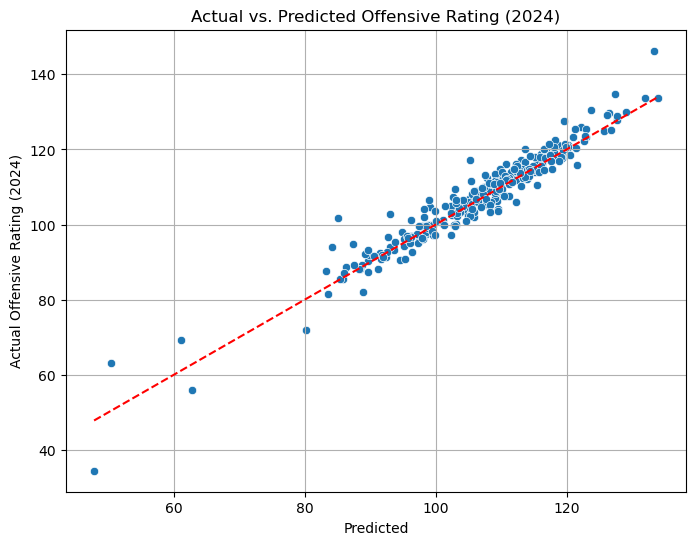

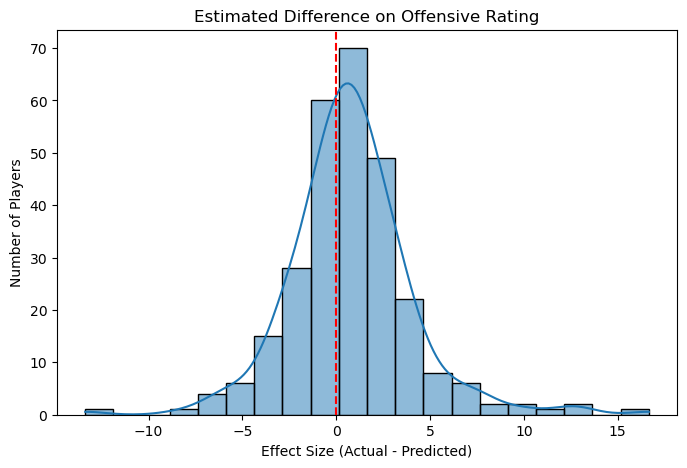

In [11]:
# Results to test the models predicted values for players who stayed 4 years at one school. 
# Model trained on 3 years and then predicts year 4 vs actual for year 4 at that school
top0, bottom0 = model_results(summary_2024_no_transfers)

In [12]:
top0

,player,Actual Offensive Rating (2024),Predicted,Estimated Difference
149,Ethan Morton,101.7,85.039242,16.660758
101,Nate Ferguson,146.3,133.289210,13.010790
261,Chris Arcidiacono,63.1,50.368518,12.731482
21,Ellis Magnuson,117.3,105.171963,12.128037
256,Harouna Sissoko,94.1,84.141284,9.958716


In [13]:
bottom0

,player,Actual Offensive Rating (2024),Predicted,Estimated Difference
239,Quoiren Waldon,34.4,47.779813,-13.379813
198,Isaiah Gross,71.9,80.238478,-8.338478
237,Zahad Munford,55.9,62.739210,-6.839210
55,Dylan Branson,82.1,88.816293,-6.716293
77,Gage Bobe,106.1,112.232731,-6.132731


Mean Squared Error: 9.16
R² Score: 0.924


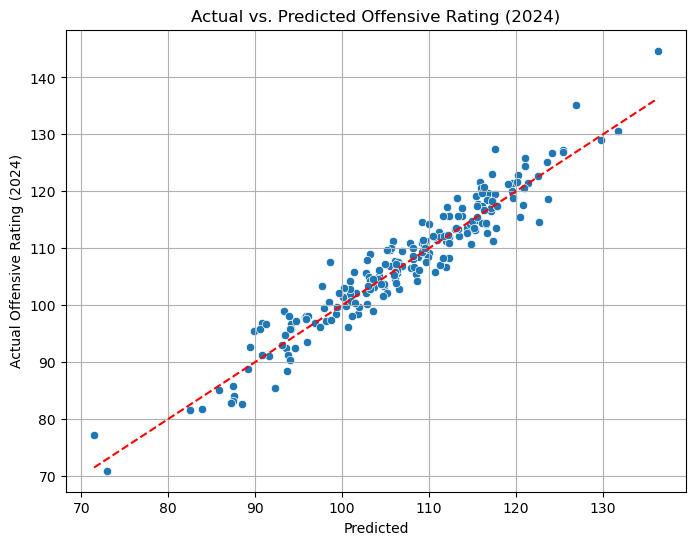

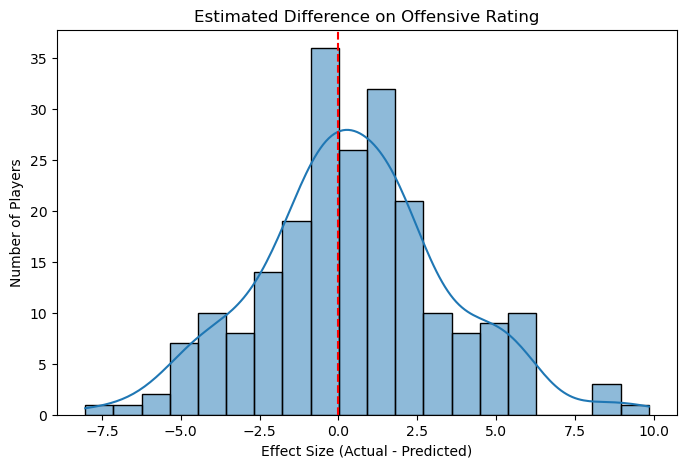

In [14]:
# Results to test the models predicted values for players who stayed 3 years at one school before transferring. 
# Model trained on 3 years and then predicted year 4 as if the player stayed at same school vs actual for year 4 at different school
top1, bottom1 = model_results(summary_2024_transfers)

In [15]:
top1

,player,Actual Offensive Rating (2024),Predicted,Estimated Difference
12,Zyon Pullin,127.4,117.556387,9.843613
162,Bas Leyte,107.6,98.658090,8.941910
13,Julian Rishwain,144.7,136.306764,8.393236
8,Latrell Wrightsell,135.1,126.940859,8.159141
50,Jared Bynum,96.9,90.829450,6.070550


In [16]:
bottom1

,player,Actual Offensive Rating (2024),Predicted,Estimated Difference
136,Wheza Panzo,114.6,122.630633,-8.030633
112,Jeremiah Oden,85.5,92.270514,-6.770514
55,Hunter Dickinson,111.3,117.332787,-6.032787
88,Evan Johnson,82.6,88.482537,-5.882537
26,Denijay Harris,88.4,93.613813,-5.213813


# Step 6: Push Data to Database

In [84]:
## 7/10/25 - The push_data_to_db needs updated ## 

# from push_db_data import push_data_to_db
# 
# push_data_to_db(summary_2024)

Data replaced to table 'ind_player_dev_predict_2024'.
